#### Overview

This notebook (1) identifies the topics associated with each video as defined by the previous notebook(s), (2) determines the feature importance of the remaining 'topic-less' tags (3) creates the final csv that will be used for modelling and analysis. 

#### Import Libraries and UDFs

In [1]:
import pandas as pd
import numpy as np
import pickle
from ast import literal_eval

In [2]:
directory = '../../YouTube Video View Analysis/'

def load_obj(fname):
    # This loads the pickled object.
    with open(directory + fname + '.pkl', 'rb') as f:
        return pickle.load(f)   

# -- UDFs for Final Table --
def getViralIndicator(value):
    if value >= 1000000:
        return 1
    else:
        return 0

def flagTopic(tags, topic):
    flag = [t for t in tags if t in topics[topic]]
    if len(flag) > 0:
        return 1
    else:
        return 0

#### Load in Classified Tags

In [3]:
tags_to_remove = ['motivationalspeechyoutuberedoriginalseries','pl5vtqduum1dmy4t5c_7dycem1zxdkozqq', 'pl5vtqduum1dk_eerei21fzkdndz2ljysh', 'bfvideo', 'bfv', 'apple']
tags_to_consolidate = {('cute', 'cuteness(websitecategory)'), ('valentines', 'valentine', 'valentine’sday')}

In [4]:
topics = load_obj('data/consolidated-topic-dictionary')
topics_misc = list(set(topics['misc']))

#### Load in Tabular BuzzFeed YouTube Data

In [5]:
# Tabluar BuzzFeed YouTube Data
data_csv_fname = "../data/bzfd_data.csv"
bzfd_df = pd.read_csv(data_csv_fname, sep=',')

# Adding / Processing Columns 
bzfd_df['processedTags'] = bzfd_df['processedTags'].apply(lambda x: literal_eval(x))
bzfd_df['logViewCount'] = bzfd_df['viewCount'].apply(lambda x: np.log(x))
bzfd_df['logDurationInSeconds'] = bzfd_df['durationInSeconds'].apply(lambda x: np.log(x))
bzfd_df['logSecondsSincePublished'] = bzfd_df['secondsSincePublished'].apply(lambda x: np.log(x))
for topic in [t for t in topics.keys() if t != 'misc']:
    bzfd_df[topic] = bzfd_df['processedTags'].apply(lambda x: flagTopic(x, topic) )

# Dummy Table for Tags    
dummies = pd.read_csv('../data/tags_as_dummies_comma.csv', sep=',')
additional_tags = dummies[['videoId', 'viewCount', 'logViewCount'] + topics_misc]
additional_tags['viralIndicator'] = additional_tags['viewCount'].apply(lambda x:  getViralIndicator(x))

/Users/chuamelia/anaconda/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


#### Create Decision Tree Classfier to Select Remaining Tags

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion='entropy')
x = additional_tags[topics_misc]
y = additional_tags['viralIndicator']

cross_val_score(clf, x, y, cv=10)
model = clf.fit(x, y)

In [7]:
feature_names = topics_misc

feature_importance = list(model.feature_importances_)

f_rank = pd.DataFrame\
.from_dict({'features': feature_names, 
            'importance': feature_importance})\
.sort_values(by='importance', ascending=True)

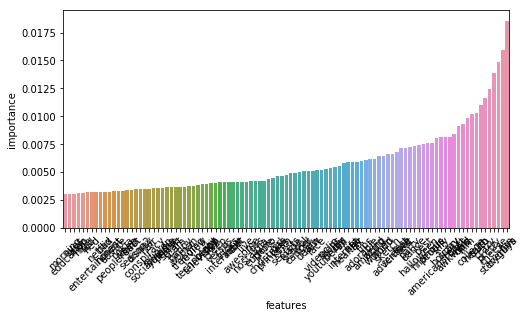

In [8]:
%matplotlib inline 
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.barplot(x='features', y='importance', data=f_rank[f_rank['importance']>0.003])
plt.setp(ax.get_xticklabels(), rotation=45)
ax

In [9]:
num_topics= [c for c in topics.keys() if c != 'misc']
len(num_topics)

25

In [10]:
len(f_rank)

540

In [11]:
# Include # of Tags so that we have no more than 100 features
n_additional_features = 100 - len(num_topics)
sorted_remaining_features = f_rank.sort_values(by='importance', ascending=False)[:n_additional_features]

#### Export Final Table for Analysis & Modelling

In [12]:
add_features = sorted_remaining_features['features'].tolist()

In [13]:
final_bzfd_df = pd.merge(bzfd_df, dummies[['videoId']+add_features], left_on='videoId', right_on='videoId')

In [34]:
final_bzfd_df.to_csv(directory + 'data/finalized_bzfd_data.csv', sep=',')

In [14]:
print(len(bzfd_df), len(final_bzfd_df ))

6418 6418
